In [1]:
import os
import json
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Force usage of Mac GPU (MPS)
device_name = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"🚀 Device selected: {device_name}")


REPO_ROOT = Path("/Users/jonaslorler/master-thesis-uq-churn")
RAW_CSV = REPO_ROOT / "data" / "raw" / "kaggle_churn" / "WA_Fn-UseC_-Telco-Customer-Churn.csv"
PROCESSED_DIR = REPO_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "Churn"

def load_and_prep_data(file_path: Path):
    df = pd.read_csv(file_path)

    # Fix TotalCharges
    if "TotalCharges" in df.columns:
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

    # Drop ID
    if "customerID" in df.columns:
        df = df.drop(columns=["customerID"])

    # Encode target
    if df[TARGET].dtype == "object":
        df[TARGET] = df[TARGET].map({"Yes": 1, "No": 0}).astype(np.int64)

    nunique = df.nunique(dropna=False)
    types = df.dtypes

    cat_cols = []
    cat_dims = {}

    # Encode categoricals / fill numerics
    for col in df.columns:
        if col == TARGET:
            continue

        if types[col] == "object" or nunique[col] < 50:
            df[col] = df[col].fillna("Unknown")
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str).values).astype(np.int64)
            cat_cols.append(col)
            cat_dims[col] = len(le.classes_)
        else:
            df[col] = df[col].fillna(df[col].mean())

    return df, cat_cols, cat_dims

# Load + preprocess
df, cat_cols, cat_dims = load_and_prep_data(RAW_CSV)

print(f"✅ Data Processed. Shape: {df.shape}")
print(f"Categorical columns found: {len(cat_cols)}")

# Save processed data + metadata
processed_csv = PROCESSED_DIR / "telco_processed.csv"
processed_meta = PROCESSED_DIR / "telco_metadata.json"

df.to_csv(processed_csv, index=False)
with open(processed_meta, "w") as f:
    json.dump({"cat_cols": cat_cols, "cat_dims": cat_dims}, f, indent=2)

print(f"💾 Saved: {processed_csv}")
print(f"💾 Saved: {processed_meta}")

# Build TabNet inputs
features = [c for c in df.columns if c != TARGET]
cat_idxs = [i for i, c in enumerate(features) if c in cat_cols]
cat_dims_list = [cat_dims[features[i]] for i in cat_idxs]  # aligned with cat_idxs

X = df[features].values.astype(np.float32)
y = df[TARGET].values.astype(np.int64)

# Train/valid/test split (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train Shape: {X_train.shape}")
print(f"Valid Shape: {X_valid.shape}")
print(f"Test Shape:  {X_test.shape}")
print(f"X dtype:     {X_train.dtype}")
print(f"#cat:        {len(cat_idxs)}")

🚀 Device selected: mps
✅ Data Processed. Shape: (7043, 20)
Categorical columns found: 16
💾 Saved: /Users/jonaslorler/master-thesis-uq-churn/data/processed/telco_processed.csv
💾 Saved: /Users/jonaslorler/master-thesis-uq-churn/data/processed/telco_metadata.json
Train Shape: (5634, 19)
Valid Shape: (704, 19)
Test Shape:  (705, 19)
X dtype:     float32
#cat:        16


In [3]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score

from pytorch_tabnet.tab_model import TabNetClassifier

# local fork of tabnet
print("predict_proba_mc exists:", hasattr(TabNetClassifier, "predict_proba_mc"))


clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims_list,
    cat_emb_dim=1,                 # can also try 2 or 4
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=20, gamma=0.9),
    mask_type="sparsemax",
    dropout=0.18,                   # <-- your deep dropout knob
    device_name=device_name,       # "mps" on Mac if available
    verbose=10,
)

# ---- fit
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=200,
    patience=30,
    batch_size=1024,
    virtual_batch_size=128,        # Ghost BatchNorm chunk size
    num_workers=0,
    drop_last=False,
)

# test metrics
proba = clf.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

auc  = roc_auc_score(y_test, proba)
ap   = average_precision_score(y_test, proba)
acc  = accuracy_score(y_test, pred)
print("\n--- Deterministic Test ---")
print(f"AUC-ROC: {auc:.4f}")
print(f"AUC-PR : {ap:.4f}")
print(f"ACC    : {acc:.4f}")

#  MC Dropout: mean prob + std prob (uncertainty proxy)
mean_proba, std_proba = clf.predict_proba_mc(X_test, n_samples=50, return_std=True)
mean_p1 = mean_proba[:, 1]
std_p1  = std_proba[:, 1]

auc_mc = roc_auc_score(y_test, mean_p1)
ap_mc  = average_precision_score(y_test, mean_p1)
acc_mc = accuracy_score(y_test, (mean_p1 >= 0.5).astype(int))

print("\n--- MC Dropout Test ---")
print(f"AUC-ROC (mean): {auc_mc:.4f}")
print(f"AUC-PR  (mean): {ap_mc:.4f}")
print(f"ACC     (mean): {acc_mc:.4f}")
print(f"Mean predicted std (class=1): {std_p1.mean():.6f}  (should be > 0 if dropout is active)")

# Optional: look at the most uncertain cases
top_unc_idx = np.argsort(-std_p1)[:10]
print("\nTop 10 uncertain examples (idx, mean_p, std_p, y):")
for i in top_unc_idx:
    print(i, float(mean_p1[i]), float(std_p1[i]), int(y_test[i]))


predict_proba_mc exists: True


/Users/jonaslorler/master-thesis-uq-churn/src/pytorch_tabnet/abstract_model.py:83: UserWarning: Device used : mps
  warnings.warn(f"Device used : {self.device}")
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


epoch 0  | loss: 0.76199 | train_auc: 0.54688 | valid_auc: 0.54552 |  0:00:01s


/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warn

epoch 10 | loss: 0.47598 | train_auc: 0.79954 | valid_auc: 0.82965 |  0:00:09s


/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warn

epoch 20 | loss: 0.4601  | train_auc: 0.81986 | valid_auc: 0.82406 |  0:00:16s


/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warn

epoch 30 | loss: 0.45213 | train_auc: 0.83392 | valid_auc: 0.82487 |  0:00:24s


/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warn

epoch 40 | loss: 0.4368  | train_auc: 0.84019 | valid_auc: 0.82755 |  0:00:31s


/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warn

epoch 50 | loss: 0.43229 | train_auc: 0.83815 | valid_auc: 0.83835 |  0:00:39s


/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warn

epoch 60 | loss: 0.43055 | train_auc: 0.84137 | valid_auc: 0.83356 |  0:00:47s


/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warn

epoch 70 | loss: 0.42808 | train_auc: 0.84497 | valid_auc: 0.83391 |  0:00:55s


/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jonaslorler/master-thesis-uq-churn/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warn


Early stopping occurred at epoch 79 with best_epoch = 49 and best_valid_auc = 0.83839

--- Deterministic Test ---
AUC-ROC: 0.8306
AUC-PR : 0.6329
ACC    : 0.7986

--- MC Dropout Test ---
AUC-ROC (mean): 0.8332
AUC-PR  (mean): 0.6306
ACC     (mean): 0.7972
Mean predicted std (class=1): 0.050046  (should be > 0 if dropout is active)

Top 10 uncertain examples (idx, mean_p, std_p, y):
210 0.37729156017303467 0.18361416459083557 1
55 0.2812441289424896 0.17026184499263763 1
42 0.2540878355503082 0.16791494190692902 1
462 0.4188626706600189 0.16478925943374634 0
486 0.33727988600730896 0.15155662596225739 1
146 0.3064824640750885 0.15092071890830994 0
457 0.3889305293560028 0.15043948590755463 1
643 0.40435606241226196 0.14751487970352173 1
190 0.37346547842025757 0.14691022038459778 0
380 0.38626745343208313 0.14582081139087677 0


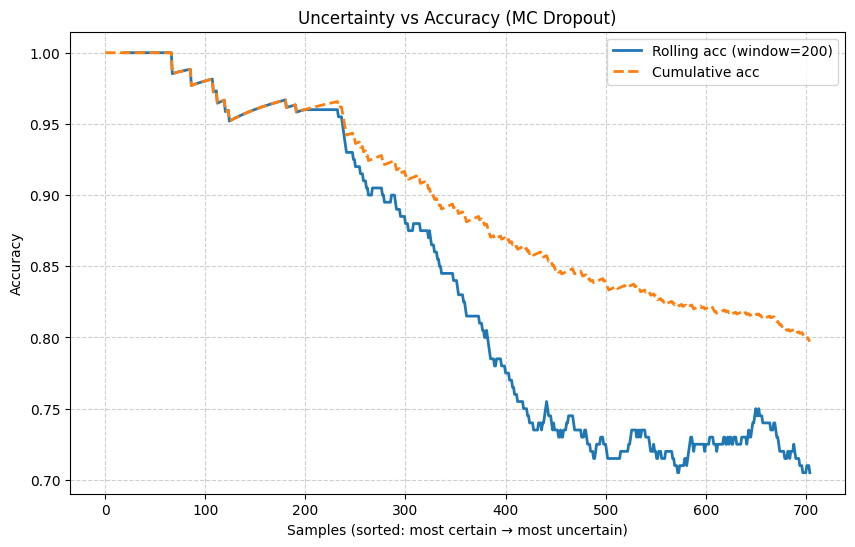

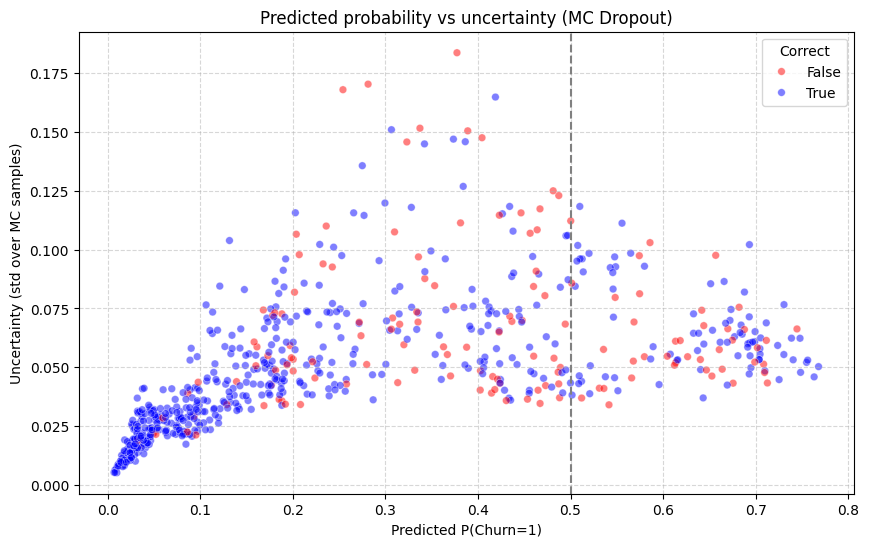

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


mc_probs = mean_proba[:, 1]
mc_uncertainty = std_proba[:, 1]

def plot_uncertainty_accuracy(y_true, y_pred, uncertainty, window=200):
    df_res = pd.DataFrame({"y": y_true, "pred": y_pred, "unc": uncertainty})

    # Correctness using 0.5 threshold
    df_res["correct"] = ((df_res["pred"] >= 0.5).astype(int) == df_res["y"]).astype(int)

    # Sort by uncertainty (most certain -> most uncertain)
    df_res = df_res.sort_values("unc").reset_index(drop=True)

    # Rolling + cumulative accuracy
    df_res["rolling_acc"] = df_res["correct"].rolling(window=window, min_periods=20).mean()
    df_res["cum_acc"] = df_res["correct"].expanding().mean()

    plt.figure(figsize=(10, 6))
    plt.plot(df_res["rolling_acc"], linewidth=2, label=f"Rolling acc (window={window})")
    plt.plot(df_res["cum_acc"], linewidth=2, linestyle="--", label="Cumulative acc")
    plt.xlabel("Samples (sorted: most certain → most uncertain)")
    plt.ylabel("Accuracy")
    plt.title("Uncertainty vs Accuracy (MC Dropout)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

def plot_prob_vs_uncertainty(y_true, y_mean, y_std):
    df_vis = pd.DataFrame({
        "Probability": y_mean,
        "Uncertainty": y_std,
        "Correct": (y_mean >= 0.5) == (y_true == 1)
    })

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_vis,
        x="Probability",
        y="Uncertainty",
        hue="Correct",
        palette={True: "blue", False: "red"},
        alpha=0.5,
        s=30
    )
    plt.title("Predicted probability vs uncertainty (MC Dropout)")
    plt.xlabel("Predicted P(Churn=1)")
    plt.ylabel("Uncertainty (std over MC samples)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.axvline(x=0.5, color="gray", linestyle="--")
    plt.show()

plot_uncertainty_accuracy(y_test, mc_probs, mc_uncertainty, window=200)
plot_prob_vs_uncertainty(y_test, mc_probs, mc_uncertainty)


In [6]:
def calculate_top_decile_lift(y_true, y_pred_proba):
    # Create a temporary DataFrame
    df_res = pd.DataFrame({'y': y_true, 'p': y_pred_proba})
    
    # Sort by predicted probability (highest risk first)
    df_res = df_res.sort_values('p', ascending=False)
    
    # Select the top 10%
    top_decile = df_res.head(len(df_res) // 10)
    
    # Calculate churn rates
    actual_churn_rate = y_true.mean()
    top_decile_churn_rate = top_decile['y'].mean()
    
    # Calculate Lift
    return top_decile_churn_rate / actual_churn_rate

# Predict on Test Set
preds = clf.predict_proba(X_test)[:, 1]

# Calculate Metrics
auc_roc = roc_auc_score(y_test, preds)
auc_pr = average_precision_score(y_test, preds)
lift = calculate_top_decile_lift(y_test, preds)

print("\n--- 📊 Thesis Baseline Results ---")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR:  {auc_pr:.4f} (Primary Metric)")
print(f"Lift:    {lift:.4f}   (Primary Metric)")


--- 📊 Thesis Baseline Results ---
AUC-ROC: 0.8306
AUC-PR:  0.6329 (Primary Metric)
Lift:    2.7468   (Primary Metric)
